In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt
from IPython.display import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM

from DiffNet.datasets.parametric.images import ImageIMBack
from e1_complex_immersed_background import Poisson, MyPrintingCallback
from torch.utils.data import DataLoader

from DiffNet.datasets.single_instances.images import ImageIMBack as ImageIMBackSingleInstance
from e7_complex_immersed_background_single_instance import Poisson as PoissonSingleInstance
from e7_complex_immersed_background_single_instance import MyPrintingCallback as MyPrintingCallbackSingleInstance

Global seed set to 42
Global seed set to 42
Global seed set to 42


In [2]:
def run_single_instance(input_nu_filename):
    filename = input_nu_filename # 'world_map.jpg'
    batch_size=1
    dataset = ImageIMBackSingleInstance(filename, domain_size=256)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    u_tensor = np.ones_like(dataset.domain)
    network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
    basecase = PoissonSingleInstance(network, batch_size=batch_size, domain_size=256)

    # ------------------------
    # 1 INIT TRAINER
    # ------------------------
    logger = pl.loggers.TensorBoardLogger('.', name="cib_single")
    csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

    early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
    checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
        dirpath=logger.log_dir, filename='{epoch}-{step}',
        mode='min', save_last=True)
    printsave = MyPrintingCallbackSingleInstance()

#     trainer = Trainer(gpus=[0],callbacks=[early_stopping],
#         checkpoint_callback=checkpoint, logger=[logger,csv_logger],
#         max_epochs=10, deterministic=True, profiler='simple')
    trainer = pl.Trainer(accelerator='gpu',devices=1,
                     callbacks=[checkpoint,printsave],
                     logger=[logger,csv_logger], 
                     max_epochs=10,
                     fast_dev_run=False
                     )

    trainer.fit(basecase, dataloader)
    torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))
    
    inputs, forcing = dataloader.dataset[0]
    nu, f, u = printsave.do_query(trainer, basecase, inputs, forcing)
    return nu, f, u

In [3]:
def query_plot_contours_and_save(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = nu.shape[0]
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax_row in axs:
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[idx,:,:]
        up = u[idx,:,:]

        im0 = axs[idx][0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[idx,0])
        im1 = axs[idx][1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[idx,1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

def query_plot_contours_and_save_SINGLEROW(dirpath,nu,f,u, saveid=None):
    outfilename = os.path.join(dirpath, 'query.png')
    if saveid != None:
        outfilename = os.path.join(dirpath, 'query_'+str(saveid)+'.png')
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2.4*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
    for ax in axs:        
        ax.set_xticks([])
        ax.set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        kp = nu[:,:]
        up = u[:,:]

        im0 = axs[0].imshow(kp,cmap='jet')
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(up,cmap='jet')
        fig.colorbar(im1, ax=axs[1]) 
    # plt.savefig(outfilename)
    # plt.close('all')
    plt.show()

In [65]:
batch_size = 16
# dirname = './complex_immersed_background/version_27/selected_query_inputs'
# case_dir = './complex_immersed_background/version_27'
# dirname = './complex_immersed_background/version_29/selected_query_inputs'
# case_dir = './complex_immersed_background/version_29'
# dirname = './complex_immersed_background/version_58/selected_query_inputs'
# case_dir = './complex_immersed_background/version_58'
# dirname = './complex_immersed_background/version_59/selected_query_inputs'
# case_dir = './complex_immersed_background/version_59'
# dirname = './complex_immersed_background/version_82/selected_query_inputs'
dirname = './complex_immersed_background/version_82/output/selected-ds2'
case_dir = './complex_immersed_background/version_82'
query_out_path = os.path.join(case_dir, 'output/ds2')
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)
dataset = ImageIMBack(dirname, domain_size=256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
network = torch.load(os.path.join(case_dir, 'network.pt'))
basecase = Poisson(network, batch_size=batch_size, domain_size=256)

logger = pl.loggers.TensorBoardLogger('.', name="complex_immersed_background")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=50, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)
printsave = MyPrintingCallback()

# trainer = Trainer(gpus=[0],callbacks=[early_stopping],
#     checkpoint_callback=checkpoint, logger=[logger,csv_logger],
#     max_epochs=150, deterministic=True, profiler='simple')
trainer = pl.Trainer(accelerator='gpu',devices=1,
                     callbacks=[early_stopping,checkpoint,printsave],
                     logger=[logger,csv_logger], 
                     max_epochs=150,
                     fast_dev_run=False
                     )

nsample = len(dataloader.dataset)
print("nsample = ", nsample)

/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /work/mech-ai/bkhara/python_virtual_envs/lightning/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


nsample =  5


In [66]:
basecase.network.eval()
for i in range(nsample//10+1):
    id0 = 10*i
    id1 = id0+10
    if id1 > nsample:
        id1 = nsample
        
    # core query code
    if id0 < id1:
        inputs, forcing = dataloader.dataset[id0:id1]
        nu_par_list, f_par_list, u_par_list = printsave.do_query(trainer, basecase, inputs, forcing)
        # query_plot_contours_and_save(query_out_path, nu_par_list, f_par_list, u_par_list, i)

In [67]:
id0

0

In [68]:
# Image(filename=os.path.join(query_out_path,'query.png')) 

In [69]:
ifRunSingleCases = False
query_input_filenames = os.listdir(dirname)
nu_single_list = []
u_single_list = []
f_single_list = []
for i in range(len(query_input_filenames)):
    fname = query_input_filenames[i]
    filename = os.path.join(dirname, fname)
    file, ext = os.path.splitext(filename)
    if ext in ['.png', '.jpg', '.bmp', '.tiff']:
        if ifRunSingleCases:
            nu, f, u = run_single_instance(filename)
            np.savez(os.path.join(query_out_path,'data_'+str(i)+'.npz'), nu=nu, u_par=u_par_list[i], u_single=u)
        else:
            temp = np.load(os.path.join(query_out_path,'data_'+str(i)+'.npz'))
            nu = temp['nu']
            u = temp['u_single']
        nu_single_list.append(nu)
        f_single_list.append(f)
        u_single_list.append(u)

In [70]:
# for nu, u in zip(nu_single_list, u_single_list):
    # query_plot_contours_and_save_SINGLEROW('',nu,f,u)

In [71]:
# for i in range(nsample):
#     nu = nu_par_list[i]
#     u_par = u_par_list[i]
#     u_single = u_single_list[i]
#     np.savez(os.path.join(query_out_path,'data_'+str(i)+'.npz'), nu=nu, u_par=u_par, u_single=u_single)

0


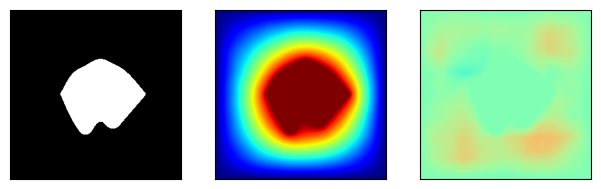

1


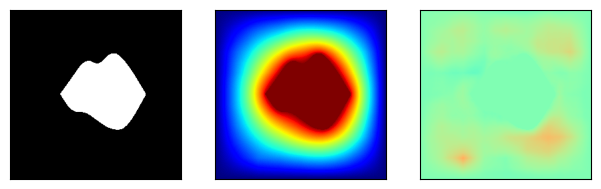

2


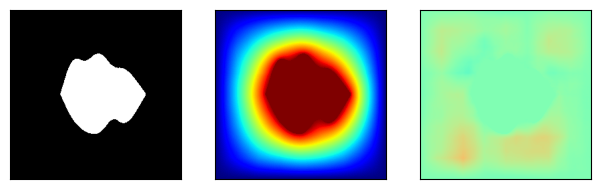

3


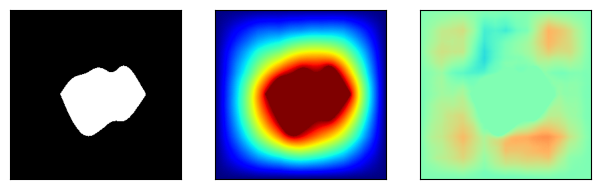

4


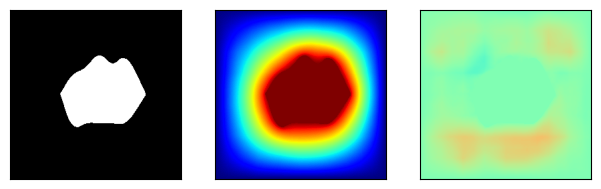

In [72]:
for i in range(nsample):
    print(i)
    # core query code
    nu = nu_par_list[i]
    u_par = u_par_list[i]
    u_single = u_single_list[i]
    
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 3
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2.5*plt_num_col,2.2*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=False, squeeze=True)
#     fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,2*plt_num_row),
#                         subplot_kw={'aspect': 'auto'},sharey=True)
    #fig.tight_layout()
#     for ax in axs:        
#         ax.set_xticks([])
#         ax.set_yticks([])
    for j in range(3):
            axs[j].set_xticks([])
            axs[j].set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[0].imshow(nu,cmap='gray_r',aspect="auto")
#         cb = fig.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.1,orientation="horizontal")
#         cb.set_ticks([0,1])
#         cb.set_ticklabels([0,1])
        im1 = axs[1].imshow(u_par,cmap='jet',aspect="auto")
#         fig.colorbar(im1, ax=axs[1]) 
#         fig.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.1,orientation="horizontal") 
        im2 = axs[2].imshow(u_par-u_single,cmap='rainbow',aspect="auto", vmin=-0.1, vmax=0.1)
#         fig.colorbar(im2, ax=axs[2]) 
#         fig.colorbar(im2, ax=axs[2], fraction=0.04, pad=0.1,orientation="horizontal") 
        rowid = 128
        colid = 128
#         im = axs[3].plot(u_par[rowid,:], 'b-')
#         im = axs[3].plot(u_single[rowid,:], 'r*',markersize=1.5)
#         im = axs[4].plot(u_par[:,colid], 'b-')
#         im = axs[4].plot(u_single[:,colid], 'r*',markersize=1.5)
    # plt.close('all')
#     plt.tight_layout()
#     fig.subplots_adjust(bottom=0, top=0, left=0, right=0)
    plt.savefig(os.path.join(query_out_path,'q_'+str(i)+'.pdf'))
    plt.show()
    plt.close('all')
# plt.savefig(os.path.join(query_out_path,'q_all-1.png'))
# plt.show() 

In [73]:
example_id = 2
u_par = u_par_list[example_id]
u_single = u_single_list[example_id]

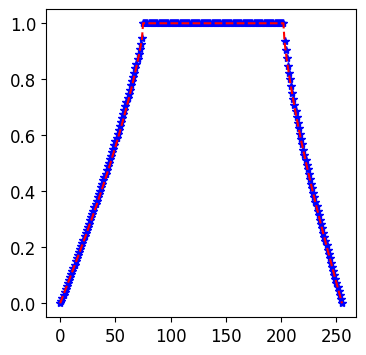

In [74]:
rowid = 128
fig = plt.figure(figsize=(4,4))
plt.plot(u_par[rowid,:], 'b*')
plt.plot(u_single[rowid,:],'r--')

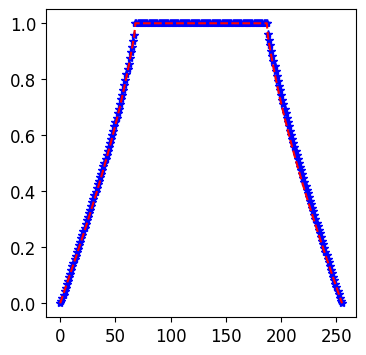

In [75]:
colid = 128
fig = plt.figure(figsize=(4,4))
plt.plot(u_par[:,colid], 'b*')
plt.plot(u_single[:,colid],'r--')